# Theory

We use a spectrograph to measure the intensity of light -- the number of photons $d$ -- as a function of the wavelength $x$.
Suppose we know that this spectrum comprises a single emission line on top of a constant background.
We would like to determine the amplitude $a$ of the emission line in the presence of both measurement noise and an unknown background level $b$. Our model for the line is that it has a Gaussian shape centred at $x = x_0$ with standard deviation $w$. Thus the expected signal (number of photons) at any position $x$ is
\begin{equation}
s \,=\, t \left[ a \exp\left(-\frac{(x-x_0)^2}{2w^2}   \right) + b \right]
\end{equation}
where $t$ is proportional to the exposure time, and so is proportional to the expected number of photons collected. If we expose for longer we expect to get more signal from both source and background, but without changing the shape of either.

We measure this signal at a number of different positions $\{x_i\}$ on the detector. If the expected number of photons at any of these positions is $s$ (which is not generally an integer), then the number of photons actually observed, $d$, follows a Poisson distribution with mean $s$, i.e.
\begin{equation}
P(d |  s) \,=\, \frac{s^de^{-s}}{d!} \ .
\end{equation}
Denoting the set of measurements as $D=\{d_i(x_i)\}$, the likelihood of the data is
\begin{equation}
P(D | x_0, w, t, a, b) \,=\, \prod_i \frac{s_i^{d_i}e^{-s_i}}{d_i!}
\end{equation}
where $s_i = s(x_i)$ and so introduces the dependence on the model parameters.


The model has five parameters, but let us assume that $x_0$, $w$, and $t$ are known. We therefore want to infer $P(a,b | D,M)$ from the data, where the model $M$ expresses that we know the shape of the line and the values of the fixed parameters (and that the noise model is Poisson). Let us adopt the minimalistic prior that $a$ and $b$ cannot be negative, but there is no upper limit. Specifically, the prior $P(a,b)$ is constant when both $a$ and $b$ are positive, and zero otherwise. The posterior is therefore 
\begin{equation}
P(a,b | D,M) \,=\, \frac{1}{Z}\prod_i \frac{s_i^{d_i}e^{-s_i}}{d_i!}
\end{equation}
for positive $(a,b)$, and zero otherwise.

The posterior has a nonlinear dependence on the parameters, so solving for the maximum, full-width at half-maximum etc. of the posterior is not analytically simple. But we can plot the posterior just by calculating it on a grid of values of $\{a_j,b_k\}$.

# Implementation in R

The code below performs all the computations described above and produces some plots.  The function "signal" predicts the signal for given parameters, and the function "logupost" gives the (natural) logarithm of the unnormalized posterior. The posterior is sampled on a uniform grid of size Nsamp $\times$ Nsamp. I then use the R function  "contour" to plot contours of this.

Note that some data points can have a very low likelihood and therefore a very low posterior density.  These -- in particular $exp(z)$ -- can become numerically identical to zero. If, as you experiment with changing values (see the suggestions after the code), you produce a posterior which is very narrow, and you use a sampling which is too coarse, then you may find that all grid evaluations give zero posterior density.  This would cause a divide by zero when you try to normalize the posteriors.  It would be straightforward to catch these errors, but this is not implemented in this code.

  a =  1.630189 +/- 0.3983222 
  b =  1.111212 +/- 0.1020915 
rho =  -0.3968818 


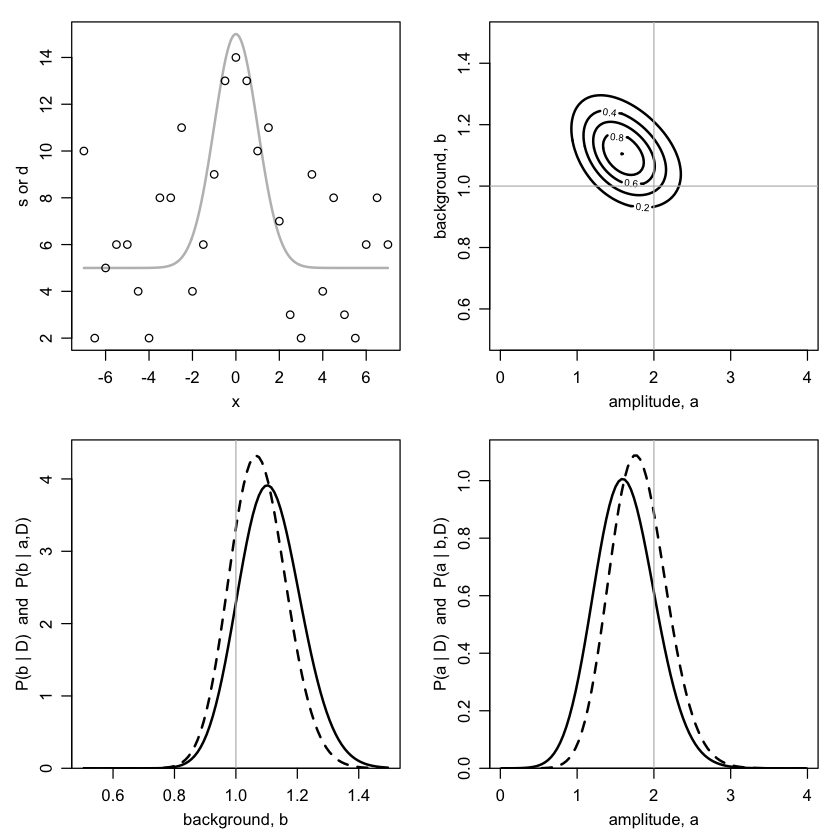

In [7]:
##### Infer posterior PDF over amplitude and background parameters

# Define function to return true signal at position x (generative model)
signal <- function(x, a, b, x0, w, t) {
  t*(a*exp(-(x-x0)^2/(2*w^2)) + b)
}

# Define function to return (natural) log posterior over (a,b).
# Prior on a and b: P(a,b) = const if a>0 and b>0, = 0 otherwise.
# Likelihood for one point is Poisson with mean d(x), so total 
# likelihood is their product. Unnormalized posterior is product of these.
# d and x are equal length vectors (or scalars). The rest are scalars.
logupost <- function(d, x, a, b, x0, w, t) {
  if(a<0 || b <0) {return(-Inf)} # the effect of the prior
  sum(dpois(d, lambda=signal(x, a, b, x0, w, t), log=TRUE))
}

# Set model parameters (true and fixed)
x0    <- 0 # centre of peak
w     <- 1 # sd of peak
atrue <- 2 # amplitude
btrue <- 1 # background
t     <- 5 # scale factor (exposure time -> sets SNR)

# Simulate some data (by drawing from the likelihood)
set.seed(205)
xdat  <- seq(from=-7*w, to=7*w, by=0.5*w)
strue <- signal(xdat, atrue, btrue, x0, w, t)
ddat  <- rpois(length(strue), strue)

# Define sampling grid to compute posterior (will be normalized
# over this range too). uniGrid spans the range 0-1 with Nsamp 
# points. This is then scaled to cover the ranges alim and blim.
alim  <- c(0.0, 4.0)
blim  <- c(0.5, 1.5)
Nsamp <- 1e2
uniGrid <- seq(from=1/(2*Nsamp), to=1-1/(2*Nsamp), by=1/Nsamp)
delta_a <- diff(alim)/Nsamp 
delta_b <- diff(blim)/Nsamp
a <- alim[1] + diff(alim)*uniGrid 
b <- blim[1] + diff(blim)*uniGrid 

# Compute log unnormalized posterior, z = ln P^*(a,b|D), on a regular grid
z <- matrix(data=NA, nrow=length(a), ncol=length(b))
for(j in 1:length(a)) {
  for(k in 1:length(b)) {
    z[j,k] <- logupost(ddat, xdat, a[j], b[k], x0, w, t)
  }
}
z <- z - max(z) # set maximum to zero

# Compute normalized marginalized posteriors, P(a|D) and P(b|D)
# by summing over other parameter. Normalize by gridding.
p_a_D <- apply(exp(z), 1, sum)
p_a_D <- p_a_D/(delta_a*sum(p_a_D))
p_b_D <- apply(exp(z), 2, sum)
p_b_D <- p_b_D/(delta_b*sum(p_b_D))

# Compute mean, standard deviation, covariance, correlation, of a and b
mean_a <- delta_a * sum(a * p_a_D)
mean_b <- delta_b * sum(b * p_b_D)
sd_a   <- sqrt( delta_a * sum((a-mean_a)^2 * p_a_D) )
sd_b   <- sqrt( delta_b * sum((b-mean_b)^2 * p_b_D) )
# To calculate the covariance I need to normalize P(a,b|D) = exp(z).
# I do it here by brute force with two loops (there are better ways in R).
# The normalization constant is Z = delta_a*delta_b*sum(exp(z)).
# This is independent of (a,b) so can be calculated outside of the loops.
# The factor delta_a*delta_b will just cancel in the expression for 
# cov_ab, so I omit it entirely.
cov_ab <- 0
for(j in 1:length(a)) {
  for(k in 1:length(b)) {
    cov_ab <- cov_ab + (a[j]-mean_a)*(b[k]-mean_b)*exp(z[j,k])
  }
}
cov_ab <- cov_ab / sum(exp(z))
rho_ab <- cov_ab / (sd_a * sd_b)
cat("  a = ", mean_a, "+/-", sd_a, "\n")
cat("  b = ", mean_b, "+/-", sd_b, "\n")
cat("rho = ", rho_ab, "\n")

# Compute normalized conditional posteriors, P(a|b,D) and P(b|a,D)
# using true values of conditioned parameters. Vectorize(func, par)
# makes a vectorized function out of func in the parameter par.
p_a_bD <- exp(Vectorize(logupost, "a")(ddat, xdat, a, btrue, x0, w, t))
p_a_bD <- p_a_bD/(delta_a*sum(p_a_bD))
p_b_aD <- exp(Vectorize(logupost, "b")(ddat, xdat, atrue, b, x0, w, t))
p_b_aD <- p_b_aD/(delta_b*sum(p_b_aD))

# Make plots

#pdf("signal_background_estimation.pdf", 7, 7)
# Plot true model and data
par(mfrow=c(2,2), mgp=c(2,0.8,0), mar=c(3.5,3.5,1,1), oma=0.1*c(1,1,1,1))
xplot <- seq(from=min(xdat), to=max(xdat), by=0.05*w)
splot <- signal(xplot, atrue, btrue, x0, w, t)
plot(xplot, splot, ylim=range(c(splot, ddat)), xlab="x", ylab="s or d", 
     type="l", col="grey", lwd=2)
points(xdat, ddat)
# Plot unnormalized 2D posterior as contours.
# Note that they are labelled by posterior density relative to peak, 
# NOT by how much probabilty they enclose.
contour(a, b, exp(z), nlevels=5, labcex=0.5, lwd=2, xlab="amplitude, a", 
        ylab="background, b")
abline(v=2,h=1,col="grey")
# Plot the 1D marginalized posteriors
plot(b, p_b_D, xlab="background, b", yaxs="i", 
     ylim=1.05*c(0,max(p_b_D, p_b_aD)), ylab="P(b | D)  and  P(b | a,D)", 
     type="l", lwd=2)
lines(b, p_b_aD, lwd=2, lty=2)
abline(v=btrue, col="grey")
plot(a, p_a_D, xlab="amplitude, a", yaxs="i", 
     ylim=1.05*c(0,max(p_a_D, p_a_bD)), ylab="P(a | D)  and  P(a | b,D)", 
     type="l", lwd=2)
lines(a, p_a_bD, lwd=2, lty=2)
abline(v=atrue, col="grey")

#dev.off()


# Exercises



Go through the above code and understand how it is working. Experiment with changing both the simulated data and the values of the parameters in the above example. Try in particular the following.

1. Change the exposure time used to generate the data. Increasing the number of photons gathered will increase the signal-to-noise ratio. Try values of $t$ of 
0.5, 1, 2, 10, 50, 100.  You will need to adjust the range over which the posterior is calculated (alim, blim) in order to sample it adequately (i.e.\ to cover its full range and to sample it at high enough resolution). If you set the limits to less than 0 you will see that the posterior is correctly truncated by the prior. A larger $t$ corresponds to more photons. You should find that this gives a more accurate and precise determination of the parameters (and a smaller $t$ a lower accuracy and precision).

2. Vary the sampling resolution of $x$ used to generate the data, but keeping the sampling range the same (so the number of data points will change). The samples are defined by
xdat  <- seq(from=-7*w, to=7*w, by=0.5*w).
In the above we have a resolution of $0.5w$, so try changing this to $0.1, 0.25, 1, 2, 3$ times $w$, for example. A better sampling of the spectral line will result in a more accurate and precise determination of its amplitude. 

3. Vary the sampling range (keep it centred on $x_0$), but keep the sampling resolution the same (so the number of data points will change). I suggest values of $\pm3w$, $\pm10w$, $\pm20w$, $\pm50w$.
If a larger fraction of the grid evaluations are dominated by the background, is the accuracy and precision with which we determine the amplitude reduced? What about the background? Is the covariance affected?

4. Vary the sampling range (keep it centred on $x_0$) between $0.5w$ and $2w$, but now with a sampling resolution of $0.1w$. In these cases we are barely sampling across the whole line. What happens to the posterior PDFs?
If we set the range to $\pm0.5w$ but have high resolution, say $0.01w$, do we improve things? 

5. Change the ratio $a/b$ use to simulate the data (keeping both positive in accordance with the prior). The smaller this is, the less prominent the line. Is the amplitude then less accurately determined?